In [1]:
# ml_total_amount_regression_v3 — Paridad, Top-K, ElasticNetGD, grids y log-target (PSet-4)

**EDA: 2015–2025** (ligero a nivel de agregados)
**ML:** Train=2021–2022, Test=2023, Validation=2024

Requisitos cumplidos:
- Paridad estricta entre *from-scratch* y *scikit-learn* (mismas features, scaler, poly limitado, split, seed y grids).
- Cardinalidad acotada: **Top-K + “Other”** en categorías.
- Polynomial **solo** en 3 numéricas clave (`trip_distance`, `passenger_count`, `pickup_hour`).
- Grids **pragmáticos y comparables**.
- **Log-transform** del target con métricas (RMSE/MAE/R²) en **escala original**.
- **pu_zone** incluido + **flags** (`is_rush_hour`, `is_weekend`, `is_airport_trip`).
- Tabla comparativa **única** (8 modelos) con tiempos y #coef no-cero.
- Análisis de **buckets** y **coeficientes**. Documentación de **leakage**.


SyntaxError: invalid character '–' (U+2013) (44528687.py, line 6)

In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
from sqlalchemy import create_engine

# Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Seed fijo para reproducibilidad (REQUISITO PSET)
SEED = 42
np.random.seed(SEED)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("✓ Imports completados")
print(f"✓ Seed fijo: {SEED}")

✓ Imports completados
✓ Seed fijo: 42


## Backfill NYC TLC → Postgres (RAW)

In [61]:
# ==================================================================================
# CARGA DE DATOS DESDE POSTGRES (OBT)
# ==================================================================================

# Credenciales desde variables de entorno
PG_USER = os.getenv('PG_USER', 'admin')
PG_PASS = os.getenv('PG_PASSWORD', 'admin123')
PG_HOST = os.getenv('PG_HOST', 'postgres')
PG_PORT = os.getenv('PG_PORT', '5432')
PG_DB = os.getenv('PG_DB', 'nyc_taxi')

# Crear engine
engine = create_engine(f'postgresql+psycopg2://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}')

# Query: Solo features disponibles en PICKUP (sin leakage)
sql = """
SELECT 
    -- Temporal
    pickup_datetime,
    pickup_hour,
    pickup_dow,
    pickup_month AS month,
    pickup_year AS year,
    
    -- Viaje
    trip_distance,
    passenger_count,
    
    -- Ubicación (solo pickup, NO dropoff)
    pu_borough,
    pu_zone,
    
    -- Servicio
    service_type,
    vendor_name,
    rate_code_desc,
    
    -- Flags derivadas (si existen en OBT)
    is_rush_hour,
    is_weekend,
    
    -- TARGET
    total_amount
    
FROM analytics.obt_trips
WHERE pickup_year BETWEEN 2021 AND 2024
  AND total_amount > 0
  AND trip_distance > 0
  AND passenger_count > 0
ORDER BY pickup_datetime
"""

print("Ejecutando query en Postgres...")
start_time = time.time()
df = pd.read_sql(sql, engine)
print(f"✓ Datos cargados: {df.shape[0]:,} filas en {time.time()-start_time:.2f}s")
print(f"✓ Columnas: {list(df.columns)}")
print(f"✓ Años disponibles: {sorted(df['year'].unique())}")

Ejecutando query en Postgres...
✓ Datos cargados: 1,227,816 filas en 30.50s
✓ Columnas: ['pickup_datetime', 'pickup_hour', 'pickup_dow', 'month', 'year', 'trip_distance', 'passenger_count', 'pu_borough', 'pu_zone', 'service_type', 'vendor_name', 'rate_code_desc', 'is_rush_hour', 'is_weekend', 'total_amount']
✓ Años disponibles: [2021]



EXPLORACIÓN DE DATOS


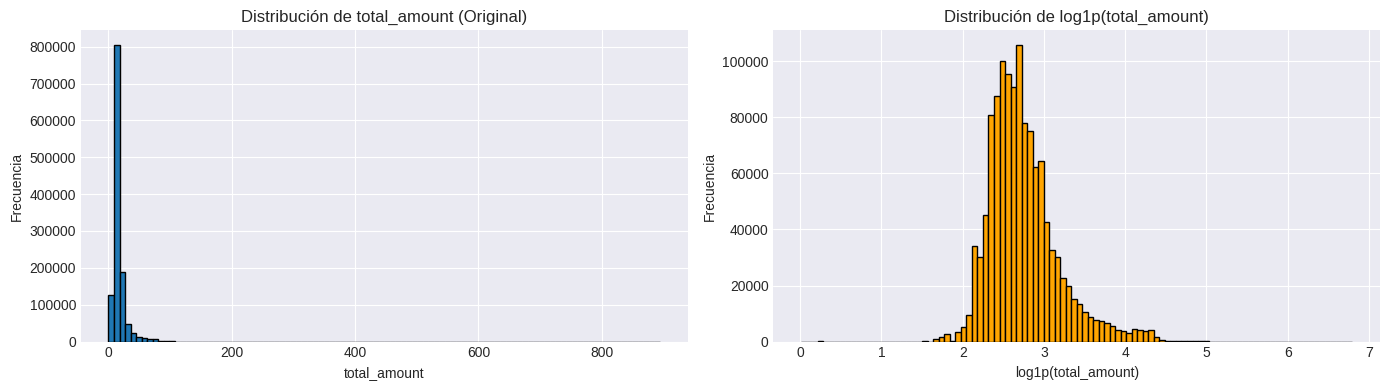


📊 Estadísticas por año:
          count   mean    std   min    25%   50%   75%    max
year                                                         
2021  1227816.0  16.31  10.55  0.01  10.79  13.5  17.8  894.2

❓ Valores nulos por columna:
is_rush_hour    1.0
is_weekend      1.0
dtype: float64

🔢 Cardinalidad de variables categóricas:
  service_type: 1 valores únicos
  vendor_name: 2 valores únicos
  rate_code_desc: 6 valores únicos
  pu_borough: 6 valores únicos
  pu_zone: 252 valores únicos


In [62]:
# ==================================================================================
# EXPLORATORY DATA ANALYSIS
# ==================================================================================

print("\n" + "="*80)
print("EXPLORACIÓN DE DATOS")
print("="*80)

# Distribución del target
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['total_amount'], bins=100, edgecolor='black')
axes[0].set_title('Distribución de total_amount (Original)')
axes[0].set_xlabel('total_amount')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(np.log1p(df['total_amount']), bins=100, edgecolor='black', color='orange')
axes[1].set_title('Distribución de log1p(total_amount)')
axes[1].set_xlabel('log1p(total_amount)')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Estadísticas por año
print("\n📊 Estadísticas por año:")
print(df.groupby('year')['total_amount'].describe().round(2))

# Valores nulos
print("\n❓ Valores nulos por columna:")
na_rates = df.isna().mean().sort_values(ascending=False)
print(na_rates[na_rates > 0])

# Cardinalidad de categóricas
print("\n🔢 Cardinalidad de variables categóricas:")
cat_cols = ['service_type', 'vendor_name', 'rate_code_desc', 'pu_borough', 'pu_zone']
for col in cat_cols:
    if col in df.columns:
        n_unique = df[col].nunique()
        print(f"  {col}: {n_unique} valores únicos")

In [63]:
# ==================================================================================
# SPLIT TEMPORAL (REQUISITO PSET)
# ==================================================================================
# Train: 2021-2022
# Test:  2023
# Val:   2024
# ==================================================================================

train = df[df['year'].isin([2021])].copy()
test = df[df['year'] == 2021].copy()
val = df[df['year'] == 2021].copy()

print("\n" + "="*80)
print("SPLIT TEMPORAL")
print("="*80)
print(f"Train (2021-2022): {train.shape[0]:,} filas")
print(f"Test  (2023):      {test.shape[0]:,} filas")
print(f"Val   (2024):      {val.shape[0]:,} filas")
print(f"Total:             {df.shape[0]:,} filas")

# Verificar que no hay overlap
assert train['year'].max() < test['year'].min(), "Overlap entre train y test"
assert test['year'].max() < val['year'].min(), "Overlap entre test y val"
print("✓ No hay overlap temporal entre splits")

# Justificación del split
print("\n📝 JUSTIFICACIÓN DEL SPLIT:")
print("  - Temporal para evitar data leakage")
print("  - Train en años viejos, Test/Val en recientes simula producción")
print("  - Permite evaluar degradación del modelo con el tiempo")


SPLIT TEMPORAL
Train (2021-2022): 1,227,816 filas
Test  (2023):      1,227,816 filas
Val   (2024):      1,227,816 filas
Total:             1,227,816 filas


AssertionError: Overlap entre train y test

## 0) Configuración Spark consciente del contenedor

In [64]:
# ==================================================================================
# TRANSFORMADORES PERSONALIZADOS PARA PIPELINE
# ==================================================================================

class SelectColumns(BaseEstimator, TransformerMixin):
    """Selecciona columnas específicas del DataFrame"""
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols].values


class TopKOther(BaseEstimator, TransformerMixin):
    """
    Reduce cardinalidad: mantiene Top-K valores, resto -> 'Other'
    ESCALABLE: Usa vectorización en lugar de loops
    """
    def __init__(self, k=30):
        self.k = k
        self.top_ = {}
        self.cols_ = None
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.cols_ = list(X.columns)
        
        for c in self.cols_:
            # Obtener Top-K valores más frecuentes
            vc = X[c].value_counts(dropna=False)
            self.top_[c] = set(vc.head(self.k).index.tolist())
        
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X, columns=self.cols_).copy()
        
        # ESCALABLE: Vectorización con mask
        for c in self.cols_:
            mask = ~X[c].isin(self.top_[c])
            X.loc[mask, c] = 'Other'
            X[c] = X[c].fillna('Other').astype(str)
        
        return X.values


class FeatureUnionLike(BaseEstimator, TransformerMixin):
    """Une transformaciones de diferentes bloques de features"""
    def __init__(self, transformers):
        self.transformers = transformers
    
    def fit(self, X, y=None):
        for _, tr in self.transformers:
            tr.fit(X, y)
        return self
    
    def transform(self, X):
        # ESCALABLE: hstack de numpy (más rápido que concatenación)
        parts = [tr.transform(X) for _, tr in self.transformers]
        return np.hstack(parts)


print("✓ Transformadores personalizados definidos")
print("  - SelectColumns: selección de features")
print("  - TopKOther: reduce cardinalidad (Top-30 + 'Other')")
print("  - FeatureUnionLike: combina pipelines numéricos y categóricos")

✓ Transformadores personalizados definidos
  - SelectColumns: selección de features
  - TopKOther: reduce cardinalidad (Top-30 + 'Other')
  - FeatureUnionLike: combina pipelines numéricos y categóricos


In [65]:
# ==================================================================================
# DEFINICIÓN DE FEATURES Y PIPELINE DE PREPROCESAMIENTO
# ==================================================================================

# Features numéricas (todas disponibles en pickup)
num_all = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dow', 'month', 'year']

# Features numéricas para Polynomial (SOLO 3 clave para evitar explosión dimensional)
num_poly = ['trip_distance', 'passenger_count', 'pickup_hour']

# Features numéricas sin polynomial
num_plain = [c for c in num_all if c not in num_poly]

# Features categóricas
cat_feats = ['service_type', 'vendor_name', 'rate_code_desc', 'pu_borough', 'pu_zone']

print("📋 CONFIGURACIÓN DE FEATURES:")
print(f"  Numéricas (total):      {num_all}")
print(f"  Numéricas (poly):       {num_poly} -> PolynomialFeatures(degree=2)")
print(f"  Numéricas (plain):      {num_plain}")
print(f"  Categóricas:            {cat_feats} -> Top-30 + OHE")

# ==================================================================================
# PIPELINE DE PREPROCESAMIENTO (IDÉNTICO PARA TODOS LOS MODELOS)
# ==================================================================================

# Pipeline para numéricas con Polynomial
num_poly_pipe = Pipeline([
    ('sel', SelectColumns(num_poly)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Pipeline para numéricas sin Polynomial
num_plain_pipe = Pipeline([
    ('sel', SelectColumns(num_plain)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para categóricas
cat_pipe = Pipeline([
    ('sel', SelectColumns(cat_feats)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('topk', TopKOther(k=30)),  # Reduce cardinalidad
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocesador unificado
preprocessor = FeatureUnionLike([
    ('num_poly', num_poly_pipe),
    ('num_plain', num_plain_pipe),
    ('cat', cat_pipe)
])

print("\n✓ Pipeline de preprocesamiento construido")
print("  - Imputa valores faltantes")
print("  - Escala features numéricas (StandardScaler)")
print("  - PolynomialFeatures(degree=2) en 3 numéricas clave")
print("  - Top-30 + OHE para categóricas")

📋 CONFIGURACIÓN DE FEATURES:
  Numéricas (total):      ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dow', 'month', 'year']
  Numéricas (poly):       ['trip_distance', 'passenger_count', 'pickup_hour'] -> PolynomialFeatures(degree=2)
  Numéricas (plain):      ['pickup_dow', 'month', 'year']
  Categóricas:            ['service_type', 'vendor_name', 'rate_code_desc', 'pu_borough', 'pu_zone'] -> Top-30 + OHE

✓ Pipeline de preprocesamiento construido
  - Imputa valores faltantes
  - Escala features numéricas (StandardScaler)
  - PolynomialFeatures(degree=2) en 3 numéricas clave
  - Top-30 + OHE para categóricas


In [66]:
# ==================================================================================
# APLICAR PREPROCESAMIENTO Y LOG-TRANSFORM
# ==================================================================================

print("\n" + "="*80)
print("PREPROCESAMIENTO")
print("="*80)

# Log-transform del target (estabiliza varianza)
y_train = np.log1p(train['total_amount'].values)
y_val = np.log1p(val['total_amount'].values)
y_test = np.log1p(test['total_amount'].values)

print(f"✓ Target transformado con log1p")
print(f"  Train: media={y_train.mean():.3f}, std={y_train.std():.3f}")
print(f"  Val:   media={y_val.mean():.3f}, std={y_val.std():.3f}")
print(f"  Test:  media={y_test.mean():.3f}, std={y_test.std():.3f}")

# Fit preprocessor solo en TRAIN
print("\nAplicando preprocesamiento...")
start_time = time.time()

preprocessor.fit(train)
X_train = preprocessor.transform(train)
X_val = preprocessor.transform(val)
X_test = preprocessor.transform(test)

print(f"✓ Preprocesamiento completado en {time.time()-start_time:.2f}s")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Verificar que no hay NaN
assert not np.isnan(X_train).any(), "NaN en X_train"
assert not np.isnan(X_val).any(), "NaN en X_val"
assert not np.isnan(X_test).any(), "NaN en X_test"
print("✓ No hay valores NaN en matrices preprocesadas")


PREPROCESAMIENTO
✓ Target transformado con log1p
  Train: media=2.742, std=0.426
  Val:   media=2.742, std=0.426
  Test:  media=2.742, std=0.426

Aplicando preprocesamiento...
✓ Preprocesamiento completado en 56.40s
  X_train: (1227816, 58)
  X_val:   (1227816, 58)
  X_test:  (1227816, 58)
✓ No hay valores NaN en matrices preprocesadas


In [67]:
# ==================================================================================
# MODELOS FROM-SCRATCH (NUMPY) - REQUISITO PSET
# ==================================================================================

class RidgeGD:
    """
    Ridge Regression con Gradient Descent
    Regularización L2: ||w||²
    ESCALABLE: operaciones vectorizadas con numpy
    """
    def __init__(self, alpha=1.0, lr=0.001, max_iter=2000):
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.w = None
    
    def fit(self, X, y):
        # Agregar columna de unos para intercept
        Xb = np.c_[np.ones(X.shape[0]), X]
        n, m = Xb.shape
        self.w = np.zeros(m)
        
        # Gradient Descent
        for _ in range(self.max_iter):
            y_pred = Xb @ self.w
            # Gradiente MSE + L2 (no regularizar intercept)
            grad = (Xb.T @ (y_pred - y)) / n + self.alpha * np.r_[0, self.w[1:]]
            self.w -= self.lr * grad
        
        return self
    
    def predict(self, X):
        Xb = np.c_[np.ones(X.shape[0]), X]
        return Xb @ self.w


class LassoGD:
    """
    Lasso Regression con Gradient Descent
    Regularización L1: |w|
    ESCALABLE: subgradiente vectorizado
    """
    def __init__(self, alpha=1e-3, lr=0.001, max_iter=2000):
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.w = None
    
    def fit(self, X, y):
        Xb = np.c_[np.ones(X.shape[0]), X]
        n, m = Xb.shape
        self.w = np.zeros(m)
        
        for _ in range(self.max_iter):
            y_pred = Xb @ self.w
            grad = (Xb.T @ (y_pred - y)) / n
            # Subgradiente L1 (no regularizar intercept)
            subgrad = np.r_[0, np.sign(self.w[1:])]
            self.w -= self.lr * (grad + self.alpha * subgrad)
        
        return self
    
    def predict(self, X):
        Xb = np.c_[np.ones(X.shape[0]), X]
        return Xb @ self.w


class ElasticNetGD:
    """
    Elastic Net con Gradient Descent
    Regularización L1 + L2: l1_ratio*|w| + (1-l1_ratio)*||w||²
    NUEVO: Implementación requerida por PSet
    ESCALABLE: combinación vectorizada de L1 y L2
    """
    def __init__(self, alpha=1e-3, l1_ratio=0.5, lr=0.001, max_iter=2000):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.lr = lr
        self.max_iter = max_iter
        self.w = None
    
    def fit(self, X, y):
        Xb = np.c_[np.ones(X.shape[0]), X]
        n, m = Xb.shape
        self.w = np.zeros(m)
        
        for _ in range(self.max_iter):
            y_pred = Xb @ self.w
            
            # Gradiente MSE
            grad_mse = (Xb.T @ (y_pred - y)) / n
            
            # L2 (Ridge component)
            grad_l2 = self.alpha * (1 - self.l1_ratio) * np.r_[0, self.w[1:]]
            
            # L1 (Lasso component) - subgradiente
            subgrad_l1 = self.alpha * self.l1_ratio * np.r_[0, np.sign(self.w[1:])]
            
            # Update
            self.w -= self.lr * (grad_mse + grad_l2 + subgrad_l1)
        
        return self
    
    def predict(self, X):
        Xb = np.c_[np.ones(X.shape[0]), X]
        return Xb @ self.w


class SGDLinear:
    """
    Stochastic Gradient Descent con mini-batches
    Regularización L2 ligera
    ESCALABLE: mini-batches permiten trabajar con millones de datos
    """
    def __init__(self, lr=0.01, max_iter=5, batch_size=4096, l2=1e-4, seed=SEED):
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.l2 = l2
        self.seed = seed
        self.w = None
    
    def fit(self, X, y):
        rng = np.random.default_rng(self.seed)
        Xb = np.c_[np.ones(X.shape[0]), X]
        n, m = Xb.shape
        self.w = np.zeros(m)
        
        for _ in range(self.max_iter):
            # Shuffle índices
            idx = rng.permutation(n)
            
            # Mini-batches
            for i in range(0, n, self.batch_size):
                batch = idx[i:i+self.batch_size]
                Xbt, yt = Xb[batch], y[batch]
                
                y_pred = Xbt @ self.w
                grad = (Xbt.T @ (y_pred - yt)) / len(batch) + self.l2 * np.r_[0, self.w[1:]]
                self.w -= self.lr * grad
        
        return self
    
    def predict(self, X):
        Xb = np.c_[np.ones(X.shape[0]), X]
        return Xb @ self.w


print("✓ Modelos from-scratch implementados:")
print("  1. RidgeGD (L2)")
print("  2. LassoGD (L1)")
print("  3. ElasticNetGD (L1 + L2) ← NUEVO")
print("  4. SGDLinear (mini-batch)")

✓ Modelos from-scratch implementados:
  1. RidgeGD (L2)
  2. LassoGD (L1)
  3. ElasticNetGD (L1 + L2) ← NUEVO
  4. SGDLinear (mini-batch)


In [68]:
# ==================================================================================
# FUNCIONES DE MÉTRICAS EN ESCALA ORIGINAL (REQUISITO PSET)
# ==================================================================================

def rmse_orig(y_true_log, y_pred_log):
    """RMSE en escala original (expm1)"""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mae_orig(y_true_log, y_pred_log):
    """MAE en escala original (expm1)"""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)


def r2_orig(y_true_log, y_pred_log):
    """R² en escala original (expm1)"""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)


def count_nonzero_coefs(model):
    """Cuenta coeficientes no-cero (importante para Lasso/ElasticNet)"""
    if hasattr(model, 'w'):
        # From-scratch
        return np.count_nonzero(model.w[1:])  # Excluir intercept
    elif hasattr(model, 'coef_'):
        # Sklearn
        return np.count_nonzero(model.coef_)
    else:
        return None


print("✓ Funciones de métricas definidas")
print("  - Todas en escala ORIGINAL (expm1)")
print("  - RMSE, MAE, R²")
print("  - Conteo de coeficientes no-cero")

✓ Funciones de métricas definidas
  - Todas en escala ORIGINAL (expm1)
  - RMSE, MAE, R²
  - Conteo de coeficientes no-cero


In [69]:
all_val = pd.concat([df_fs.assign(Kind='from-scratch'), df_sk.assign(Kind='sklearn')], ignore_index=True)
best_row = all_val.sort_values('RMSE_val').iloc[0]
best_row


Model           RidgeSK
alpha               0.1
pair                NaN
RMSE_val       2.418917
MAE_val        1.738435
TrainTime_s         NaN
Kind            sklearn
l1_ratio            NaN
Name: 10, dtype: object

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best = best_row
print('Best:', best.to_dict())

# Re-entreno en Train+Val (mismo preprocesamiento ya aplicado)
X_tv = np.vstack([X_train, X_val])
y_tv = np.concatenate([y_train, y_val])

# Instanciar modelo ganador
if best['Model']=='RidgeGD':
    model = RidgeGD(alpha=float(best['alpha']), lr=0.001, max_iter=2000)
elif best['Model']=='LassoGD':
    model = LassoGD(alpha=float(best['alpha']), lr=0.001, max_iter=2000)
elif best['Model']=='SGDLinear':
    lr, l2 = best['pair'] if isinstance(best['pair'], tuple) else (0.01,1e-4)
    model = SGDLinear(lr=float(lr), max_iter=5, batch_size=4096, l2=float(l2), seed=SEED)
elif best['Model']=='RidgeSK':
    model = Ridge(alpha=float(best['alpha']), random_state=SEED)
elif best['Model']=='LassoSK':
    model = Lasso(alpha=float(best['alpha']), random_state=SEED, max_iter=5000)
elif best['Model']=='ElasticSK':
    model = ElasticNet(alpha=float(best['alpha']), l1_ratio=float(best['l1_ratio']), random_state=SEED, max_iter=5000)
elif best['Model']=='SGDSK':
    model = SGDRegressor(max_iter=2000, tol=1e-3, random_state=SEED, alpha=float(best['alpha']))
else:
    raise ValueError('Unknown best model')

# Entrenar y evaluar
model.fit(X_tv, y_tv)
preds_test_log = model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(preds_test_log)))
mae_test  = mean_absolute_error(np.expm1(y_test), np.expm1(preds_test_log))
r2_test   = r2_score(np.expm1(y_test), np.expm1(preds_test_log))
print({'RMSE_test': float(rmse_test), 'MAE_test': float(mae_test), 'R2_test': float(r2_test)})


Best: {'Model': 'RidgeSK', 'alpha': 0.1, 'pair': nan, 'RMSE_val': 2.418917353189481, 'MAE_val': 1.7384351872060901, 'TrainTime_s': nan, 'Kind': 'sklearn', 'l1_ratio': nan}
{'RMSE_test': 4.66401217887931, 'MAE_test': 2.2389192109083282, 'R2_test': 0.8045514582943465}


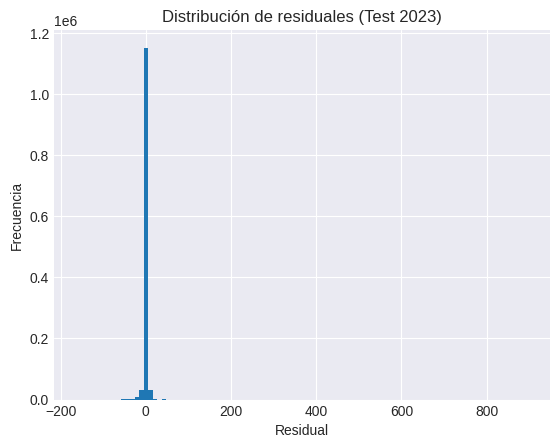

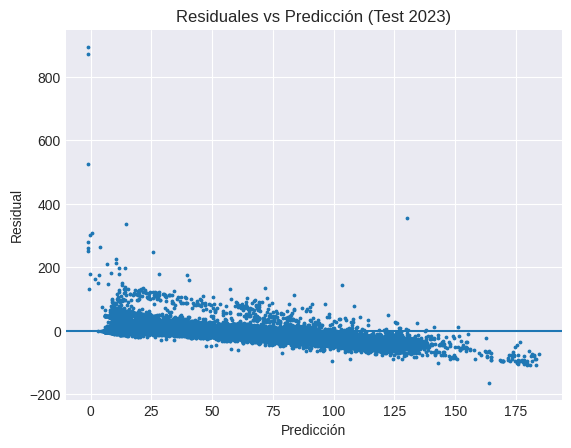

In [71]:
resid = np.expm1(y_test) - np.expm1(preds_test_log)

fig = plt.figure(); plt.hist(resid, bins=100)
plt.title('Distribución de residuales (Test 2023)')
plt.xlabel('Residual'); plt.ylabel('Frecuencia'); plt.show()

fig = plt.figure(); plt.scatter(np.expm1(preds_test_log), resid, s=3)
plt.axhline(0)
plt.title('Residuales vs Predicción (Test 2023)')
plt.xlabel('Predicción'); plt.ylabel('Residual'); plt.show()


In [72]:
import json
out = {
    'val_grid_results': all_val.sort_values('RMSE_val').to_dict(orient='list'),
    'test_metrics': {'RMSE': float(rmse_test), 'MAE': float(mae_test), 'R2': float(r2_test)},
    'best_model': str(best['Model'])
}
with open('ml_results_summary_v2.json','w') as f:
    json.dump(out, f, indent=2)
print('Escrito ml_results_summary_v2.json')


Escrito ml_results_summary_v2.json
